## import modules

In [281]:
import random
import os 
import numpy as np 
import tensorflow as tf
# Set a random seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
import pandas as pd 
from transformers import AutoTokenizer, TFAutoModel
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

In [282]:
## Load data 

synthetic_user_data = pd.read_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/synthetic_data_half_cleaned_mac_full_v1.csv")
import ast 
df = synthetic_user_data.copy()
# Fill missing values if necessary
df.fillna({'Course Taken': 'no course','course title': 'no course'}, inplace=True)
df["Course Taken"]=df["Course Taken"].apply(lambda x:x.replace("NAN","No Course"))

df["Course Skills"]=df["Course Skills"].apply(lambda x:ast.literal_eval(x))
df["Course Skills"].apply(lambda x: x if len(x)!=0 else "no skills")
#df["Course title"]=df["Course title"].apply(lambda x:x.replace("NAN","No Course"))
def set_to_string(skill_set):
    if not skill_set:  # Checks if the set is empty
        return 'no skills' 
    # Check if skill_set is a string that needs to be evaluated
    if isinstance(skill_set, str):
        try:
            # Try to evaluate the string as a set
            skill_set = ast.literal_eval(skill_set)
        except (ValueError, SyntaxError):
            # Handle cases where the string is not a valid set
            pass  # You might want to return a default value or handle this case as needed
    # Convert to string if it's a set or list
    if isinstance(skill_set, (set, list)):
        return ', '.join(skill_set)
    return skill_set 

set_columns = ['Current Skills', 'Next Skills', 'Skill Gap', 'Course Skills']
for col in set_columns:
    print(col)
    #df[col]=df[col].apply(lambda x:ast.literal_eval(x))
    df[col] = df[col].apply(set_to_string)





#df = pd.read_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/df_embedding_bert.csv")

# Loading the JSON file back into a dictionary
import json
Job_progression_dictionary_file_path = "/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/job_progression_dictionary.json"

with open(Job_progression_dictionary_file_path, 'r') as json_file:
    sorted_full_job_progression_dict_lower = json.load(json_file)

#print(sorted_full_job_progression_dict_lower)
# Output: {'name': 'John', 'age': 30, 'city': 'New York'}




Current Skills
Next Skills
Skill Gap
Course Skills


In [285]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
df = df[df["random next job"]!=1].drop_duplicates()

In [292]:
len(df["Current Job"].unique())

43

In [293]:
## Build embedding 


# Initialize tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=512)
    outputs = model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, 1).numpy()[0]  # Mean pooling

'''
text_columns = ['Current Job', 'Next Job', 'Current Skills', 'Next Skills', 'Skill Gap', 'course title', 'Course Skills', 'Course Taken']
for col in text_columns:
    df[f'{col}_embedding'] = df[col].apply(get_embedding)
'''

unique_job_titles=set()
for key,value in sorted_full_job_progression_dict_lower.items():
    unique_job_titles.add(key)
    for each in value:
        unique_job_titles.add(each)
unique_job_titles

job_embeddings = {}
for job in unique_job_titles:
    embedding = get_embedding(job)  # Using the same function as in your model
    job_embeddings[tuple(embedding)] = job  # Storing embedding as tuple for dictionary key


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [294]:
def batch_encode(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="tf", padding=True, truncation=True, max_length=512)
        outputs = model(inputs)
        batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, 1).numpy()
        embeddings.extend(batch_embeddings)
    return embeddings
text_columns = ['Current Job', 'Next Job', 'Current Skills', 'Next Skills', 'Skill Gap', 'course title', 'Course Skills', 'Course Taken']
embeddings_dict = {}
for col in text_columns:
    embeddings_dict[col] = batch_encode(df[col].tolist())

np.savez_compressed('/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/all_embeddings_v1.npz', **embeddings_dict)
loaded_embeddings = np.load('/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/all_embeddings_v1.npz')


In [304]:
#'Next Skills', 'Skill Gap', 'course title', 'Course Skills'
feature_columns = ['Current Job', 'Current Skills',]
# Stack embeddings horizontally (axis=1)
all_embeddings = np.hstack((loaded_embeddings[each] for each in feature_columns)) # Add other embeddings as needed
y_job = loaded_embeddings['Next Job']
#y_course = loaded_embeddings['Course Taken_embedding']

from sklearn.model_selection import train_test_split

# Assuming 'target' is your target array
X_train, X_test, y_job_train, y_job_test = train_test_split(all_embeddings, y_job, test_size=0.1, random_state=42)

# Flatten the embeddings if they are not already
X_train_flat = X_train.reshape(X_train.shape[0],len(feature_columns), -1)
X_test_flat = X_test.reshape(X_test.shape[0],len(feature_columns), -1)

# Verify the new shapes
print("X_train_flat shape:", X_train_flat.shape)
print("X_test_flat shape:", X_test_flat.shape)
X_train_tensor = tf.convert_to_tensor(X_train_flat, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_flat, dtype=tf.float32)

print("X_train_tensor shape:", X_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)


y_job_train_tensor = tf.convert_to_tensor(y_job_train, dtype=tf.float32)
y_job_test_tensor = tf.convert_to_tensor(y_job_test, dtype=tf.float32)

print("Y_job_train_tensor shape:", y_job_train_tensor.shape)
print("Y_job_test_tensor shape:", y_job_test_tensor.shape)


/var/folders/17/gws30jys63j9xx5l0mwr5r4r0000gq/T/ipykernel_35121/3892250985.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_embeddings = np.hstack((loaded_embeddings[each] for each in feature_columns)) # Add other embeddings as needed


X_train_flat shape: (4859, 2, 768)
X_test_flat shape: (540, 2, 768)
X_train_tensor shape: (4859, 2, 768)
X_test_tensor shape: (540, 2, 768)
Y_job_train_tensor shape: (4859, 768)
Y_job_test_tensor shape: (540, 768)


In [305]:
## Attention layer 



class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        a = K.softmax(e)
        a = K.expand_dims(a, axis=-1)
        weighted_output = x * a
        return K.sum(weighted_output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [306]:
## Build model architecture 

'''
model_job = Sequential()

# Add the first LSTM layer with input_shape
model_job.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(6, 768)))

# Add dropout for regularization
model_job.add(Dropout(0.2))

# Add the second LSTM layer
# No need to specify input_shape as it's not the first layer of the model
model_job.add(Bidirectional(LSTM(128)))

# Another dropout layer
model_job.add(Dropout(0.2))


# Final Dense layer to output the embeddings
model_job.add(Dense(768))  # Make sure this matches the size of your embeddings
'''
'''
model_job = Sequential()

# First LSTM layer
model_job.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(6, 768)))
model_job.add(Dropout(0.2))

# Additional LSTM layer, with return_sequences=True since there's another LSTM layer following
model_job.add(Bidirectional(LSTM(128, return_sequences=True)))
model_job.add(Dropout(0.2))

# Last LSTM layer, return_sequences is False by default
model_job.add(Bidirectional(LSTM(128)))
model_job.add(Dropout(0.2))

# Dense layers can also be added for further processing
model_job.add(Dense(256, activation='relu'))
model_job.add(Dropout(0.2))

# Output layer
model_job.add(Dense(768))  
'''

model_job = Sequential()

# First LSTM layer
model_job.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(len(feature_columns), 768)))
model_job.add(Dropout(0.2))

# Second LSTM layer
model_job.add(Bidirectional(LSTM(128, return_sequences=True)))
model_job.add(Dropout(0.2))

# Attention Layer
model_job.add(AttentionLayer())

# Dense layer (optional, depending on your specific problem)
model_job.add(Dense(256, activation='relu'))
model_job.add(Dropout(0.2))

# Output layer
model_job.add(Dense(768))  




model_job.compile(optimizer='Adam', loss='mean_squared_error')
history = model_job.fit(X_train_tensor, y_job_train_tensor, epochs=50, batch_size=32, validation_split=0.1)
loss = model_job.evaluate(X_test_tensor, y_job_test_tensor)
print(f"Test Loss: {loss}")

#Make Predictions
predictions = model_job.predict(X_test_tensor)


Epoch 1/50
137/137 [==============================] - 17s 59ms/step - loss: 0.0332 - val_loss: 0.0218
Epoch 2/50
137/137 [==============================] - 6s 42ms/step - loss: 0.0221 - val_loss: 0.0193
Epoch 3/50
137/137 [==============================] - 6s 41ms/step - loss: 0.0200 - val_loss: 0.0184
Epoch 4/50
137/137 [==============================] - 5s 39ms/step - loss: 0.0191 - val_loss: 0.0180
Epoch 5/50
137/137 [==============================] - 5s 40ms/step - loss: 0.0187 - val_loss: 0.0177
Epoch 6/50
137/137 [==============================] - 5s 38ms/step - loss: 0.0185 - val_loss: 0.0178
Epoch 7/50
137/137 [==============================] - 5s 39ms/step - loss: 0.0183 - val_loss: 0.0177
Epoch 8/50
137/137 [==============================] - 6s 45ms/step - loss: 0.0182 - val_loss: 0.0174
Epoch 9/50
137/137 [==============================] - 6s 41ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 10/50
137/137 [==============================] - 6s 45ms/step - loss: 0.0179 - val_l

In [307]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def find_closest_job_title(prediction, embedding_dict):
    highest_similarity = -1
    closest_job = None

    # Ensure prediction is a 2D array
    if len(prediction.shape) == 1:
        prediction = prediction.reshape(1, -1)

    for ref_embedding_tuple, job_title in embedding_dict.items():
        # Convert tuple to NumPy array and reshape to 2D
        ref_embedding = np.array(ref_embedding_tuple).reshape(1, -1)

        similarity = cosine_similarity(prediction, ref_embedding)[0][0]
        if similarity > highest_similarity:
            highest_similarity = similarity
            closest_job = job_title

    return closest_job



predicted_job_titles = [find_closest_job_title(pred, job_embeddings) for pred in predictions]

actual_job_titles = [find_closest_job_title(actual_emb, job_embeddings) for actual_emb in y_job_test]
matches = [pred == actual for pred, actual in zip(predicted_job_titles, actual_job_titles)]
accuracy = sum(matches) / len(matches)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 20.93%


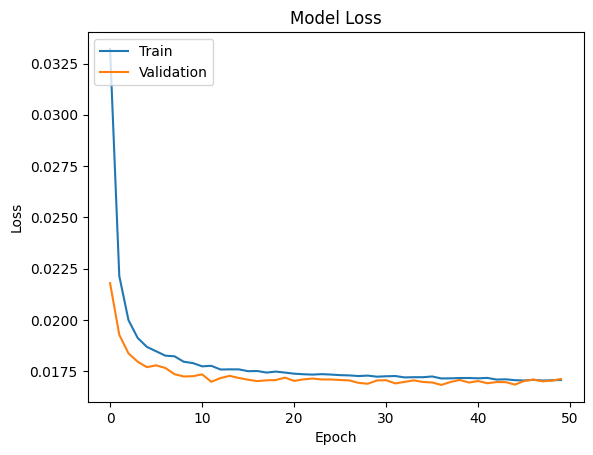

In [308]:
import matplotlib.pyplot as plt
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
## Seq2Seq model 

